# Forecasting

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('master_orders.csv')

In [22]:
df

,Order ID,Customer ID,Created at,Financial Status,Net Revenue,Contribution Margin,Lineitem sku,Lineitem quantity,Lineitem total price,Gross Margin %,Order Year,Order Month,Days Since Order
0,110460500,1220,2025-11-11,pending,1112.0,1062.0,HERB002,5,900,38.888889,2025,11,63
1,110460501,1116,2025-11-29,paid,1406.0,1356.0,HERB003,4,1200,36.666667,2025,11,45
2,110460502,1376,2025-11-15,paid,1406.0,1376.0,HERB003,4,1200,36.666667,2025,11,59
3,110460503,1165,2025-11-05,paid,1032.0,962.0,HERB002,5,900,38.888889,2025,11,69
4,110460504,1379,2025-11-06,paid,249.6,199.6,HERB005,1,220,36.363636,2025,11,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,110460492,1380,2025-12-16,paid,414.8,364.8,HERB002,2,360,38.888889,2025,12,28
533,110460493,1468,2025-12-04,paid,1012.0,962.0,HERB002,5,900,38.888889,2025,12,40
534,110460494,1436,2025-12-12,paid,1465.0,1435.0,HERB001,5,1250,36.000000,2025,12,32
535,110460498,1153,2025-12-04,paid,394.8,324.8,HERB002,2,360,38.888889,2025,12,40


### 1. Data prep

In [23]:
daily_sales = df.groupby(['Created at','Lineitem sku']).agg({
    'Lineitem quantity' : 'sum',
    'Net Revenue': 'sum'}).reset_index()

In [24]:
sku_list = daily_sales['Lineitem sku'].unique()

In [25]:
date_range = pd.date_range(start=daily_sales['Created at'].min(), end=daily_sales['Created at'].max(), freq='D')

In [26]:
full_df = pd.DataFrame(
    [(date, sku) for date in date_range for sku in sku_list],
    columns=['Created at', 'Lineitem sku']
)

In [27]:
full_df['Created at'] = pd.to_datetime(full_df['Created at'])
daily_sales['Created at'] = pd.to_datetime(daily_sales['Created at'])

daily_sales = full_df.merge(daily_sales, on=['Created at', 'Lineitem sku'], how='left').fillna(0)

### 2. Top 3 sku forecast(80% revenue)

In [28]:
top_skus = df.groupby('Lineitem sku')['Net Revenue'].sum().nlargest(3).index
daily_sales_top = daily_sales[daily_sales['Lineitem sku'].isin(top_skus)]

### 3. Feature Engineering

In [29]:
def create_features(df):
    df = df.copy()
    
    df['day_of_week'] = df['Created at'].dt.dayofweek
    df['month'] = df['Created at'].dt.month
    df['quarter'] = df['Created at'].dt.quarter
    df['is_weekend'] = (df['Created at'].dt.dayofweek >= 5).astype(int)

    df['lag_7'] = df['Lineitem quantity'].shift(1)
    df['lag_7'] = df['Lineitem quantity'].shift(7)
    df['lag_30'] = df['Lineitem quantity'].shift(30)

    df['rolling_mean_7'] = df['Lineitem quantity'].rolling(7, min_periods =1).mean()
    df['rolling_std_7'] = df['Lineitem quantity'].rolling(7, min_periods=1).std()

    df['revenue_per_unit'] = df['Net Revenue'] / (df['Lineitem quantity'] +1)

    return df.dropna()

daily_sales_featured = daily_sales_top.groupby('Lineitem sku').apply(create_features).reset_index(drop=True)

### 4. Prophet Forecasting

In [30]:
forecast_results = []
for sku in top_skus:
    sku_data = daily_sales_featured[daily_sales_featured['Lineitem sku'] == sku][['Created at', 'Lineitem quantity']].rename(columns={'Created at' : 'ds',
                                                             'Lineitem quantity' : 'y'})
    sku_data['y'] = sku_data['y'].clip(lower=0)
    
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.fit(sku_data)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    
    forecast_results.append({
        'sku': sku,
        'model': model,
        'forecast': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)})

12:49:33 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
forecast_results

[{'sku': 'HERB003',
  'model': <prophet.forecaster.Prophet at 0x2653d9f6ba0>,
  'forecast':            ds      yhat  yhat_lower  yhat_upper
  0  2025-12-01  7.467779    1.869416   13.082230
  1  2025-12-02  6.063772    0.609412   11.744814
  2  2025-12-03  6.064042    0.663944   11.595945
  3  2025-12-04  0.577924   -5.389259    5.998515
  4  2025-12-05  4.591624   -1.232567   10.277157
  ..        ...       ...         ...         ...
  56 2026-01-26  9.600121    3.566524   14.709714
  57 2026-01-27  8.196114    2.377740   14.269313
  58 2026-01-28  8.196384    2.425827   13.375004
  59 2026-01-29  2.710266   -2.944524    8.284153
  60 2026-01-30  6.723966    1.322094   12.190655
  
  [61 rows x 4 columns]},
 {'sku': 'HERB005',
  'model': <prophet.forecaster.Prophet at 0x2653d9f7230>,
  'forecast':            ds      yhat  yhat_lower  yhat_upper
  0  2025-12-01  4.979279    0.028557    9.852865
  1  2025-12-02  2.979546   -1.953573    8.175113
  2  2025-12-03  4.179385   -1.233903    

### ML Regression Forecast

In [32]:
X = daily_sales_featured[['day_of_week', 'month', 'quarter', 'is_weekend', 
                         'lag_7', 'lag_30', 'rolling_mean_7']]
y = daily_sales_featured['Lineitem quantity']

In [33]:
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae_scores.append(np.mean(np.abs(y_val - y_pred)))

In [34]:
print(f"RF Cross-Validation MAE: {np.mean(mae_scores):.1f} units")

RF Cross-Validation MAE: 4.2 units


In [35]:
final_rf = RandomForestRegressor(n_estimators=200, random_state=42)
final_rf.fit(X, y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

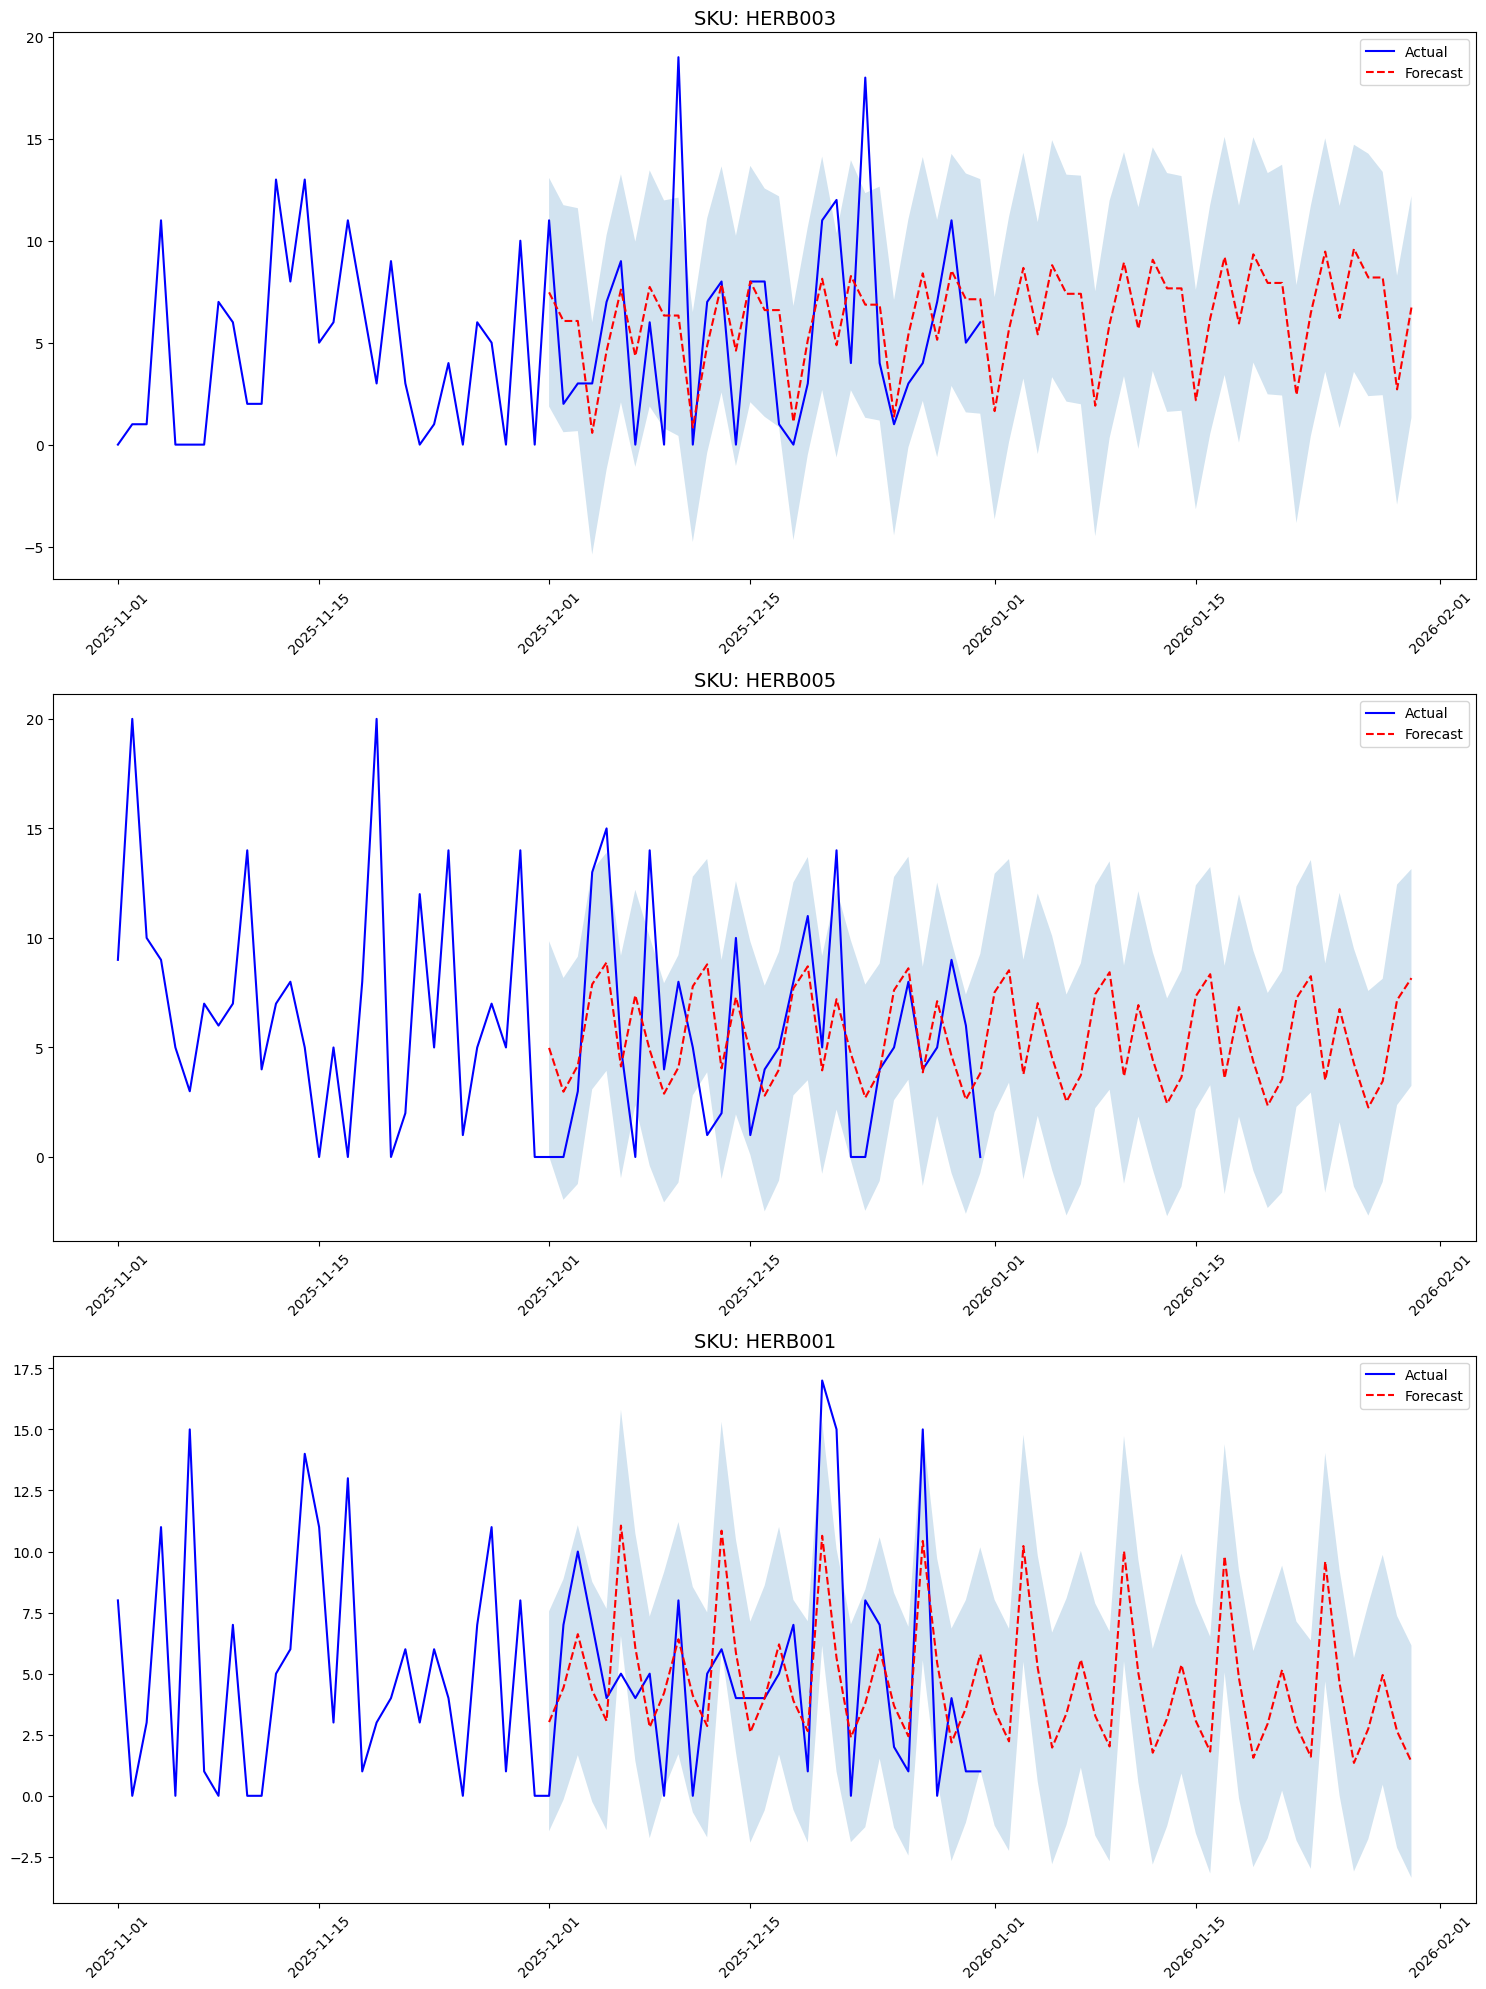

In [36]:
plt.figure(figsize=(15, 20))

for i, sku in enumerate(top_skus):
    plt.subplot(len(top_skus), 1, i+1)
    sku_data = daily_sales[daily_sales['Lineitem sku'] == sku]
    sku_forecast = next((item['forecast'] for item in forecast_results if item['sku'] == sku), None)
    
    if sku_forecast is None:
        print(f"Warning: Forecast not found for SKU {sku}")
        continue
    plt.plot(sku_data['Created at'], sku_data['Lineitem quantity'], 'b-', label='Actual')
    plt.plot(sku_forecast['ds'], sku_forecast['yhat'], 'r--', label='Forecast')
    plt.fill_between(sku_forecast['ds'], sku_forecast['yhat_lower'], sku_forecast['yhat_upper'], alpha=0.2)
    plt.title(f'SKU: {sku}', fontsize=14)
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('forecast_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
df

,Order ID,Customer ID,Created at,Financial Status,Net Revenue,Contribution Margin,Lineitem sku,Lineitem quantity,Lineitem total price,Gross Margin %,Order Year,Order Month,Days Since Order
0,110460500,1220,2025-11-11,pending,1112.0,1062.0,HERB002,5,900,38.888889,2025,11,63
1,110460501,1116,2025-11-29,paid,1406.0,1356.0,HERB003,4,1200,36.666667,2025,11,45
2,110460502,1376,2025-11-15,paid,1406.0,1376.0,HERB003,4,1200,36.666667,2025,11,59
3,110460503,1165,2025-11-05,paid,1032.0,962.0,HERB002,5,900,38.888889,2025,11,69
4,110460504,1379,2025-11-06,paid,249.6,199.6,HERB005,1,220,36.363636,2025,11,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,110460492,1380,2025-12-16,paid,414.8,364.8,HERB002,2,360,38.888889,2025,12,28
533,110460493,1468,2025-12-04,paid,1012.0,962.0,HERB002,5,900,38.888889,2025,12,40
534,110460494,1436,2025-12-12,paid,1465.0,1435.0,HERB001,5,1250,36.000000,2025,12,32
535,110460498,1153,2025-12-04,paid,394.8,324.8,HERB002,2,360,38.888889,2025,12,40


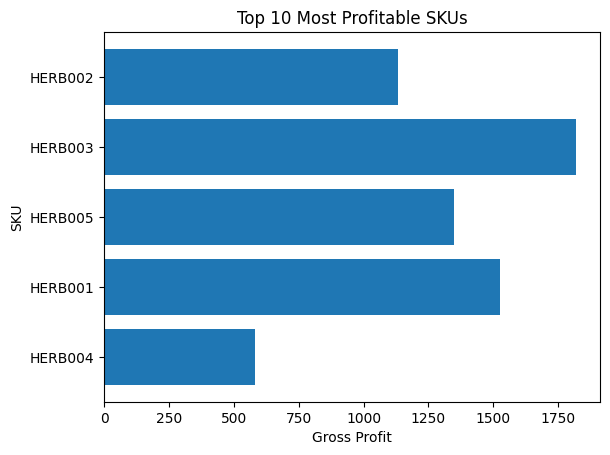

In [41]:
plt.figure()
plt.barh(df['Lineitem sku'], df['Net Revenue'])
plt.xlabel('Gross Profit')
plt.ylabel('SKU')
plt.title('Top 10 Most Profitable SKUs')
plt.gca().invert_yaxis()

plt.show()

